# Physics-Informed Neural Network
The idea is to include in the loss function for our neural network a term to guide the network to output values like a physical system, i.e. to solve / integrate an ODE.

An example of this is to find the solution for $$u' = f(u, t)$$ where $u(t)$ will be a neural network. 

The always respect an initial condition $u(0) = u_0$, we parametrize a solution $g(t)$:
$$ g(t) = u_0 + t u(t) $$

Ths, the loss of the function is:
$$ \mathcal{L}(g) = \int^1_0 (g'(t) - f(g, t))^2 dt $$

We try this for the example $$ u' = \cos 2 \pi t$$ with boundary condition $u_0 = 1$.

We know the true solution through analytical integration to be $1 + \frac{\sin 2 \pi t}{2 \pi}$ 

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

T = torch.tensor

u0 = 1

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

u = Net()
output = u(T([1.0]))

In [20]:
def g(t):
    return u0 + t*u(t)

In [26]:
import math
from torch import pi
eps = math.sqrt(torch.finfo(torch.float32).eps)

ts = torch.linspace(0, 1, 100).reshape((-1, 1))

def loss():
    u_prime = (g(ts + eps) - g(ts))/eps
    f = torch.cos(2 * pi * ts)
    return torch.mean((u_prime - f)**2)

assert loss() > 0

In [27]:
from torch.optim import SGD

opt = SGD(u.parameters(), lr=.01)

Ls = []
for _ in range(5000):
    u.zero_grad()
    L = loss()
    Ls.append(L.detach())
    L.backward()
    opt.step()

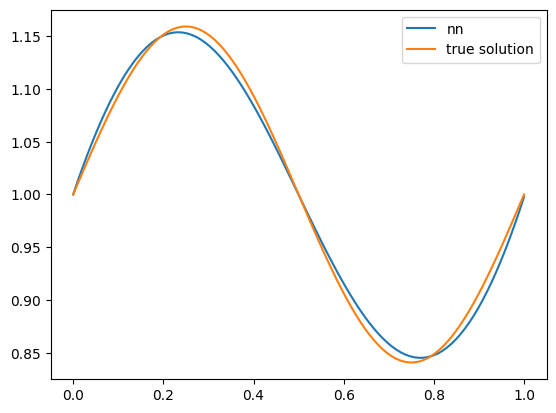

In [28]:
import matplotlib.pyplot as plt

true_solution = u0 + torch.sin(2*pi*ts) / (2*pi)

plt.plot(ts, g(ts).detach(), label="nn")
plt.plot(ts, true_solution, label="true solution")
plt.legend()

Let us also plot $u(t)$:

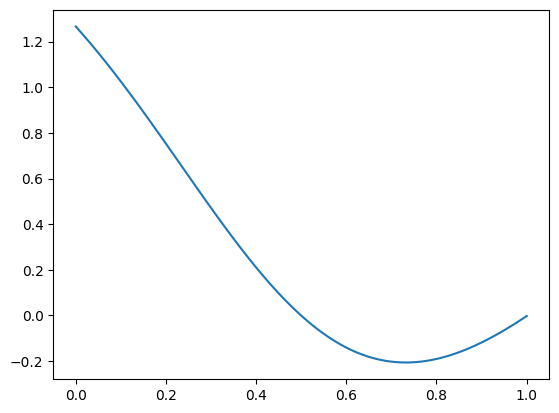

In [29]:
plt.plot(ts, u(ts).detach())